# Introduction to DDT analysis 

Let's just start this story by plotting a simple sine wave....


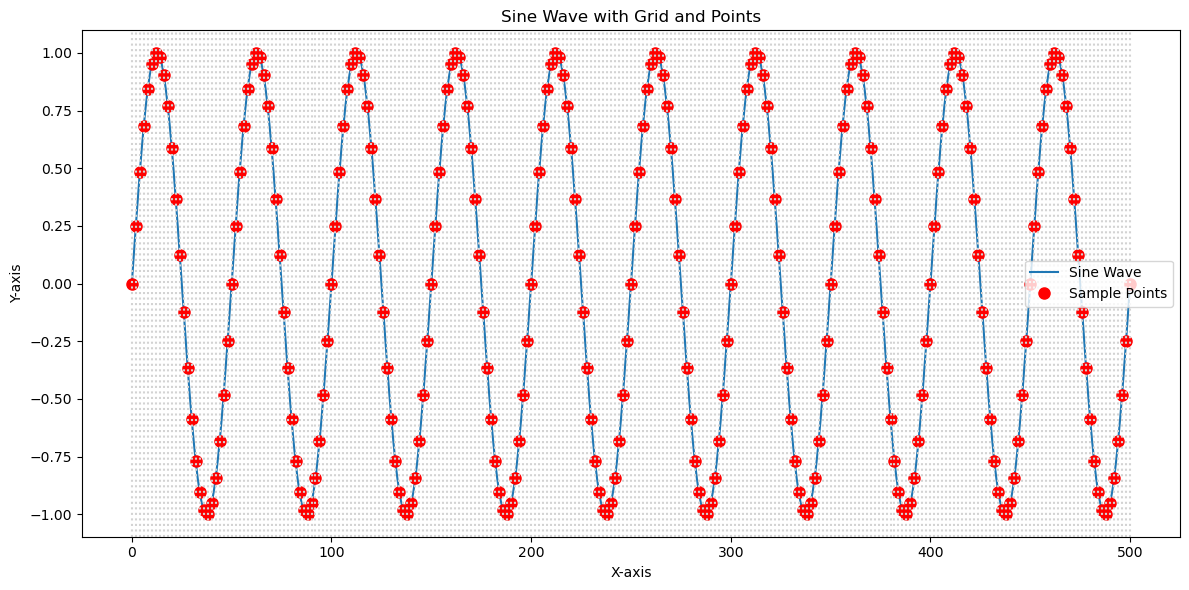

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Define parameters
wavelength = 50
amplitude = 1
start = 0
end = 500 
samples_per_wavelength = 50  # Increase for smoother curve
ss=25 # sub samples per wavelength for red dots

pss=math.floor(samples_per_wavelength/ss)

# Generate x and y values
x = np.linspace(start, end, int((end - start) / wavelength * samples_per_wavelength)+1)
y = amplitude * np.sin(2 * np.pi * x / wavelength)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the sine wave
ax.plot(x, y, label='Sine Wave')

# Add points to the curve
ax.plot(x[::pss], y[::pss], 'ro', markersize=8, label='Sample Points')  # Red circles, every 10th point

# Create grid lines at integer x values
for i in x[::pss]:
    ax.axvline(x=i, color='lightgray', linestyle=':')

# Customize plot appearance
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Sine Wave with Grid and Points')
ax.legend()
ax.grid(False)  # Turn off the default grid to avoid overlap

# Show the plot
plt.tight_layout() # Prevents labels from being cut off
plt.show()


### Discussion

1) If we have 10 waves and 25 samples per wave, how many red points are required to prepresent the series?

2) If we instead represent the data as a sinewave how many numbers are required to represent the data?


So we can represent the data either in physical space, or in Fourrier space, that is, as a sum of sine waves, each described by its amplitude and phase.  

Discrete Fourier transform (DFT): The DFT of a series of n data points (where n is typically assumed to be even for simplicity, though DFTs can be calculated for odd n) produces n complex numbers. These complex numbers represent the frequency components of the signal.  Each complex number corresponds to a specific frequency. However, these frequency components aren't just sine waves. They represent both sine and cosine waves (or, equivalently, sine waves with phase shifts).



## Mathematical Introduction to FFT Analysis for Time Series

Let $x[n]$ represent a discrete-time signal, where $n$ is an integer index representing the time sample, and $n = 0, 1, ..., N-1$, with $N$ being the total number of samples. The Discrete Fourier Transform (DFT) of $x[n]$, denoted as $X[k]$, is defined as:

$$X[k] = \sum_{n=0}^{N-1} x[n] e^{-j 2\pi kn/N}$$

where $k = 0, 1, ..., N-1$ represents the frequency index, and $j$ is the imaginary unit ($j^2 = -1$). The $e^{-j 2\pi kn/N}$ term represents a complex sinusoid at frequency $k/N$.

The DFT decomposes the signal $x[n]$ into a sum of complex sinusoids, each with a specific frequency and amplitude. The output $X[k]$ is a complex-valued sequence, where the magnitude $|X[k]|$ represents the amplitude of the frequency component $k/N$, and the phase $\arg(X[k])$ represents the phase shift of that component.

The inverse DFT (IDFT) reconstructs the original signal $x[n]$ from its DFT coefficients $X[k]$:

$$x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] e^{j 2\pi kn/N}$$

The Fast Fourier Transform (FFT) is an efficient algorithm to compute the DFT and IDFT. It leverages the symmetry and periodicity properties of the complex exponential term to reduce the computational complexity from $O(N^2)$ for the direct DFT calculation to $O(N \log N)$.

For a real-valued input signal $x[n]$, the DFT output $X[k]$ exhibits conjugate symmetry, i.e., $X[k] = X^*[N-k]$, where $*$ denotes complex conjugation. This means that the negative frequency components ($k > N/2$) are redundant, and we typically focus on the positive frequency components ($k \le N/2$).

The frequency resolution $\Delta f$ of the DFT is given by:

$$\Delta f = \frac{f_s}{N}$$

where $f_s$ is the sampling frequency (the number of samples per unit time). The maximum frequency that can be represented without aliasing is the Nyquist frequency, which is half the sampling frequency:

$$f_{Nyquist} = \frac{f_s}{2}$$

The frequency corresponding to the $k$-th DFT coefficient is:

$$f_k = k \Delta f = \frac{k f_s}{N}$$

The amplitude spectrum of the signal is obtained by computing the magnitude $|X[k]|$ of the DFT coefficients. The power spectrum is given by $|X[k]|^2$.

Windowing functions, such as Hamming or Hanning windows, are often applied to the input signal $x[n]$ before computing the DFT to reduce spectral leakage, which occurs when the signal is not periodic within the observation window.
Key Change:

Dollar Signs: All LaTeX mathematical expressions are now enclosed within $ (for inline) or $$ (for display) delimiters.


In [1]:
#%pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import urllib.request
import cftime
import datetime

In [45]:

def analyze_time_series_fft(time_series, times, units):
    """
    Analyzes a time series using FFT and returns the frequencies, periods, and amplitudes.

    Args:
        time_series (np.ndarray or xr.DataArray): The time series data.
        time_coords (np.ndarray or xr.DataArray): Corresponding time coordinates.

    Returns:
        tuple: (frequencies, periods, amplitudes)
    """
   

    # Calculate the sampling period in days
    time_diffs = np.diff(times)
    if len(np.unique(time_diffs)) != 1:
        raise ValueError("Time coordinates must be evenly spaced.")

    # Determine time units and convert to days
    if isinstance(times[0], datetime.datetime):
        time_diff_days = np.mean([td.total_seconds() / (60 * 60 * 24) for td in time_diffs])
        print ("here")
    else:
        try:
            # units = time_coords.units
            print (units, " units")
            if 'second' in units.lower():
                print ("sec detected")
                time_diff_days = np.mean(time_diffs) / (60 * 60 * 24)
            elif 'minute' in units.lower():
                time_diff_days = np.mean(time_diffs) / (60 * 24)
            elif 'hour' in units.lower():
                print ("hours detected")
                time_diff_days = np.mean(time_diffs) / 24
            elif 'day' in units.lower():
                time_diff_days = np.mean(time_diffs)
            else:
                time_diff_days = np.mean(time_diffs) / (60 * 60 * 24)  # assume seconds if units not recognized.
        except AttributeError:
            time_diff_days = np.mean(time_diffs) / (60 * 60 * 24)  # assume seconds if no units attribute.

    # Compute the FFT
    fft_result = np.fft.fft(time_series)

    # Calculate frequencies (in cycles per day)
    frequencies = np.fft.fftfreq(len(time_series), time_diff_days)

    # Calculate periods (in days) - handle zero frequency carefully
    periods = np.zeros_like(frequencies)
    positive_freq_indices = frequencies > 0
    periods[positive_freq_indices] = 1 / frequencies[positive_freq_indices]
    periods[frequencies == 0] = np.inf  # Period is infinite for zero frequency

    # Calculate amplitudes
    amplitudes = np.abs(fft_result)

    return frequencies, periods, amplitudes






We will also introduce a separate polotting routine in order to keep things clean


In [ ]:

def plot_fft_spectrum(frequencies, periods, amplitudes):
    """
    Plots the frequency spectrum.

    Args:
        frequencies (np.ndarray): Frequencies (cycles/day).
        periods (np.ndarray): Periods (days).
        amplitudes (np.ndarray): Amplitudes.
    """

    positive_freq_indices = frequencies > 0

    fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axes

    ax.plot(periods[positive_freq_indices], amplitudes[positive_freq_indices])
    ax.set_xlabel("Period (days)")
    ax.set_ylabel("Amplitude (log scale)")
    ax.set_title("Frequency Spectrum")
    ax.grid(True)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(365 * 10,0.1)

    return fig,ax

decode
seconds since 1970-01-01  units
sec detected


Text(1, 1, 'day')

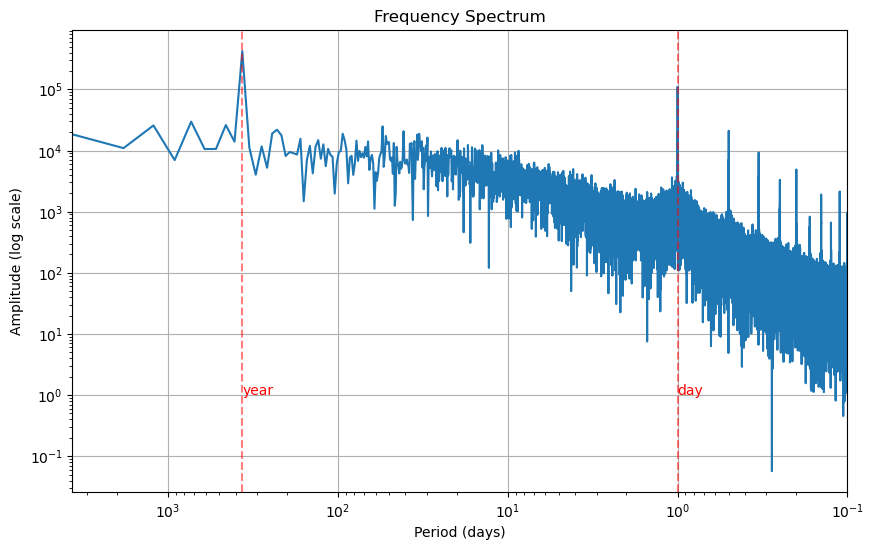

In [49]:

# Download example data
# url = "https://downloads.psl.noaa.gov/Datasets/era5/hourly/air.2m.2023.nc"
# filename = "air.2m.2023.nc"
# urllib.request.urlretrieve(url, filename)

datadir="/Users/tompkins/DATA/era5/hourly/"
filename=datadir+"t2m_t.nc"

# Open the NetCDF file
decode_times=False
ds = xr.open_dataset(filename, decode_times=decode_times)
if not decode_times:
    print ("decode")
    time_units = ds["valid_time"].units
    time_values = ds["valid_time"].values

    # Extract the base date from the time units
    base_date_str = time_units.split('since ')[1]

    # Convert seconds to datetime objects
    times = cftime.num2date(time_values, units = time_units, calendar = 'standard')

    # Replace the time coordinate
    # ds['time'] = datetimes

# Select a specific location and time range
lat = 45.6
lon = 13.7
t2m = ds["t2m"].sel(latitude=lat, longitude=lon,method='nearest')
# time = ds['time']

# Perform FFT analysis
frequencies, periods, amplitudes = analyze_time_series_fft(t2m, time_values, time_units)
fig,ax=plot_fft_spectrum(frequencies, periods, amplitudes)

ax.axvline(x=365, color='red', linestyle='--',alpha=0.5)
ax.text(365,1,"year",color='red')
ax.axvline(x=1, color='red', linestyle='--',alpha=0.5)
ax.text(1,1,"day",color='red')


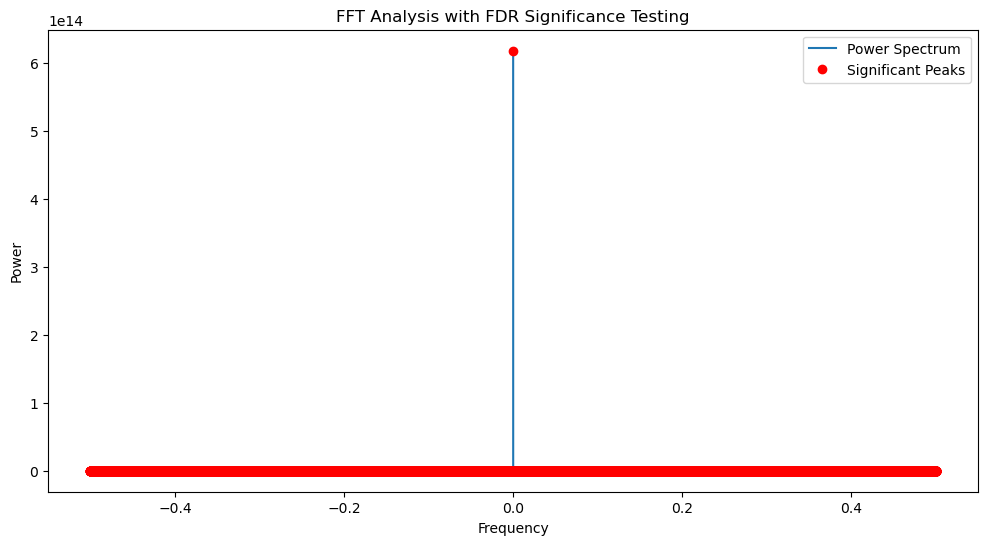

In [76]:
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy.stats import norm
import netCDF4 as nc
import matplotlib.pyplot as plt

# Load the NetCDF file
def load_netcdf(file_path, variable_name):
    dataset = nc.Dataset(file_path, 'r')
    time_series = dataset.variables[variable_name][:,0,0]
    dataset.close()
    return time_series

# Perform FFT analysis
def fft_analysis(time_series, sample_rate):
    fft_out = fft(time_series)
    freqs = fftfreq(len(time_series), 1.0 / sample_rate)
    powers = np.abs(fft_out) ** 2
    return freqs, powers

# Statistical significance testing using FDR
def fdr_test(powers, alpha=0.05):
    from scipy.stats import rankdata
    ranks = rankdata(powers)
    m = len(powers)
    critical_values = norm.ppf(1 - alpha / (2 * m), loc=0, scale=1)
    significant_peaks = ranks >= critical_values
    return significant_peaks

# Main program
if __name__ == "__main__":

    
    datadir="/Users/tompkins/DATA/era5/hourly/"
    file_path=datadir+"t2m_t_av.nc"
    
    variable_name = "t2m"
    sample_rate = 1.0  # Sample rate of your time series (e.g., 1 Hz)

    time_series = load_netcdf(file_path, variable_name)
    freqs, powers = fft_analysis(time_series, sample_rate)

    significant_peaks = fdr_test(powers)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(freqs, powers, label="Power Spectrum")
    plt.plot(freqs[significant_peaks], powers[significant_peaks], 'ro', label="Significant Peaks")
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.title("FFT Analysis with FDR Significance Testing")
    plt.legend()
    plt.show()
